This is a working notebook explores using k-means and GMM to identify areas of flood and shadow within an urban flood image. 

# Import packages and set working directories

In [1]:
# Import packages
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
# from scipy.misc import bytescale
import shapely
from shapely.wkt import loads
import pandas as pd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
import earthpy.plot as ep

%matplotlib inline

In [ ]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [130]:
# Set directory to area of interest containing raster stack
aoi = "koumassi_focus_ps"
band_path = os.path.join("dg-data", aoi +"\\")
index_path = os.path.join("dg-data",aoi,"outputs"+"\\")
# all_dg_bands = glob(band_path+"*band_*")
# all_dg_bands.sort()
index_rasters = glob(index_path+"*_copy*")
index_rasters.sort()

In [133]:
# Create raster stack of ndwi, msi, ndvi
index_stack_path = os.path.join(outputs_path, aoi + "_index_stack.tif")
index_stack, index_stack_meta = es.stack(index_rasters,
                                             index_stack_path)

outputs_path = os.path.join(band_path, "outputs\\")
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
index_stack_path = os.path.join(outputs_path, aoi + "_index_stack.tif")

# Open raster stack of interest - make 8 band and RGB-NIR stack

In [3]:
# Open 8 band WV2 raster stack
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    all_bands_stack_meta = src.profile
    files_out_meta = src.profile
    
# Update files out meta for writing out single files
files_out_meta['count']=1

In [134]:
# Open index stack (MSI, NDVI, NDWI1)
with rio.open(index_stack_path) as src:
    index_stack = src.read()
    indec_stack_meta = src.profile
    index_stack_files_out_meta = src.profile
    
# Update files out meta for writing out single files
index_stack_files_out_meta['count']=1

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2604a26af98>)

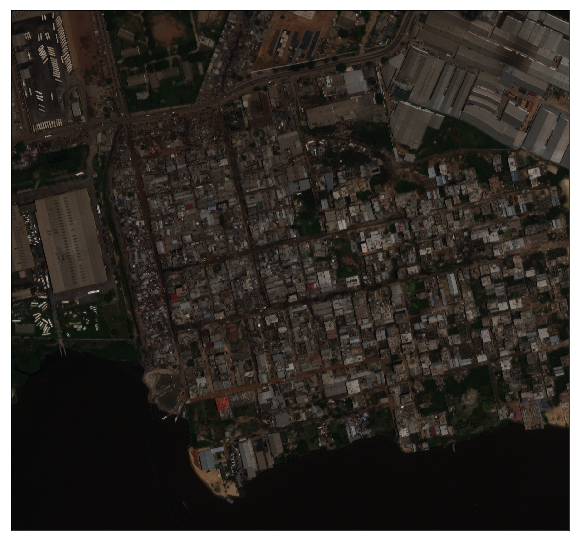

In [4]:
# Make RGB stack
rgb_bands = glob(band_path+"*band_[1,2,4,6]*")
rgb_bands.sort()
rgb_bands_path = os.path.join(outputs_path, aoi + "_rgb_bands.tif")
rgb_bands, rgb_bands_meta = es.stack(rgb_bands,
                                             rgb_bands_path)

ep.plot_rgb(rgb_bands,rgb=(2, 1, 0))

# Define K-means clustering model and run on all_bands and RBG-NIR stacks

In [110]:
from sklearn.cluster import KMeans
from scipy.ndimage import generic_filter

# Define classifier
nclass = 8
clf_kmeans = KMeans(n_clusters=nclass, random_state=10)

In [111]:
# Reshape array 
im_arr = np.rollaxis(all_bands_stack, 0, 3)
X = im_arr.reshape(-1,8)
                                      
# ndvi = np.expand_dims(((TestData[:,3] - TestData[:,2]) / (TestData[:,3] + TestData[:,2])), axis=1)
# ndvi[np.isnan(ndvi)] = -9999
#TestData = np.hstack((TestData, ndvi))

In [112]:
# Fit the KMeans classifier to the 8-band raster stack
predictedClass = clf_kmeans.fit_predict(X, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass += 1

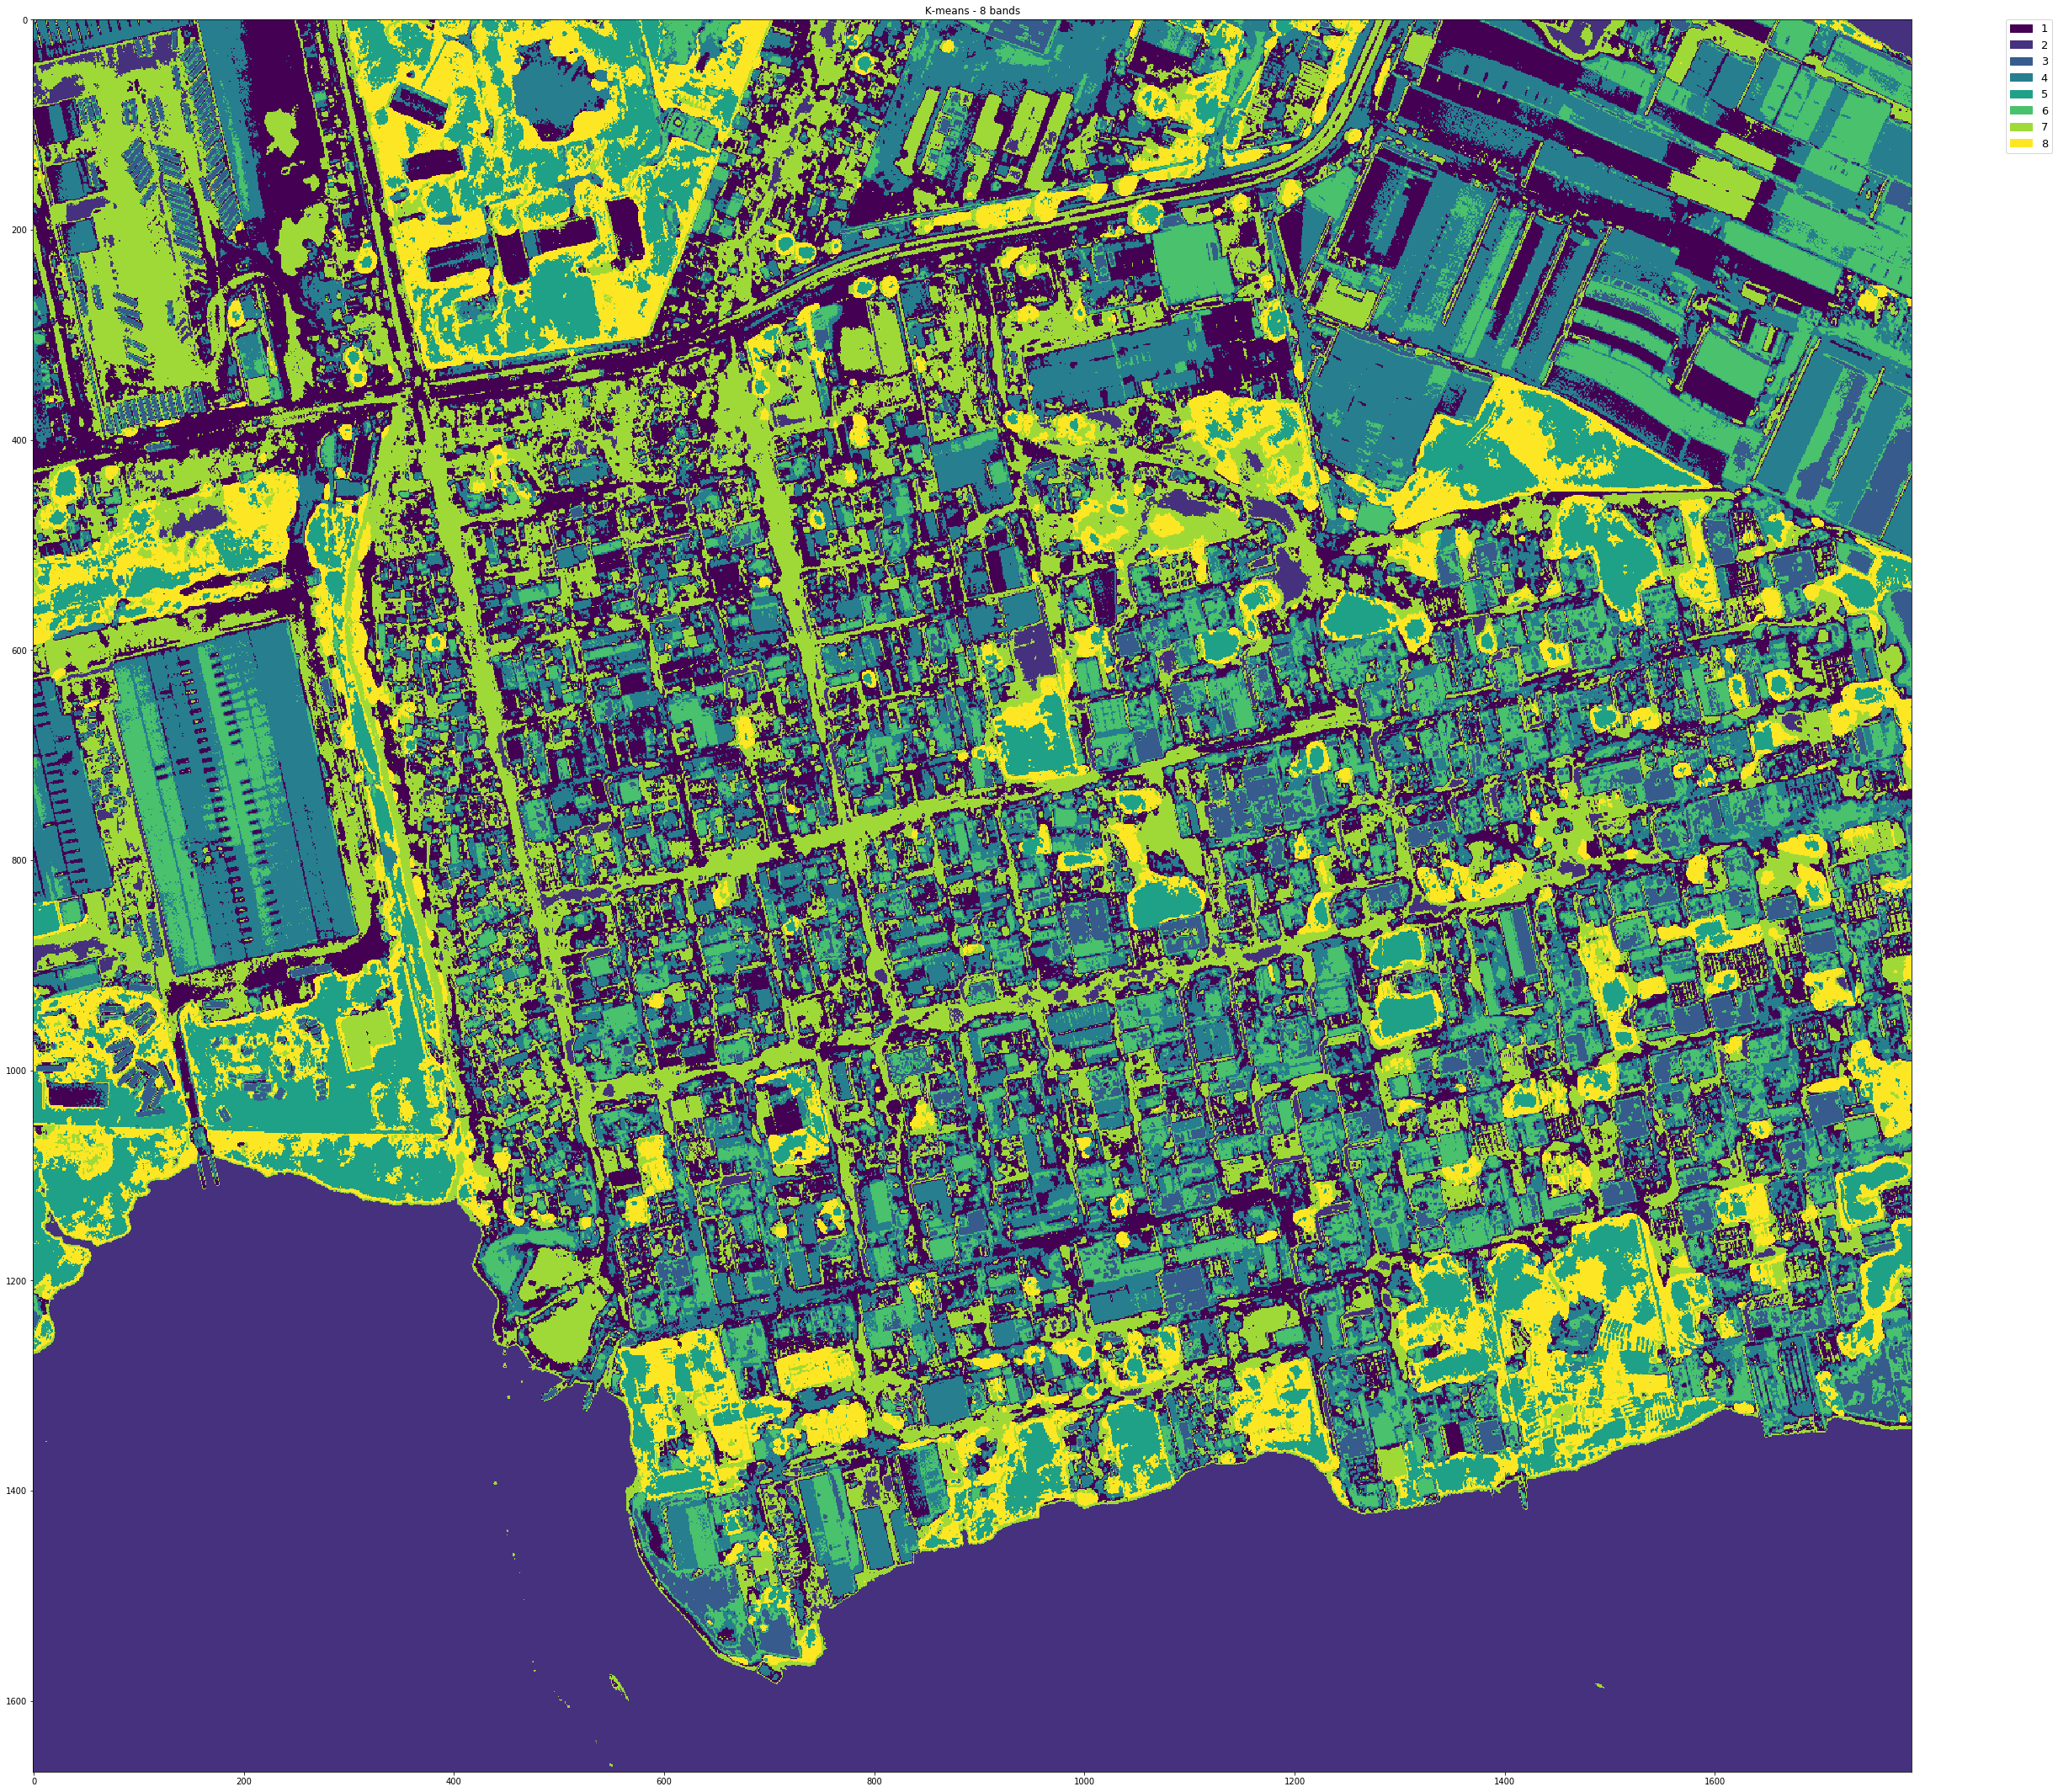

In [117]:
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data = predictedClass.reshape(im_arr.shape[:2])
im = ax.imshow(pred_data)
values = np.unique(pred_data)
cat_names = ["1","2","3","4","5","6","7","8"]
ep.draw_legend(im,titles=cat_names)
plt.title("K-means - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

In [90]:
# Calculate and add texture to all_bands_stack, creating 9-dim array

# Add in a sliding window calculation for texture
radius = 5
texture = generic_filter(im_arr[:,:,1], np.std, size=2*radius)
texture_newaxis = texture[np.newaxis,:]
bands_and_texture = np.vstack((all_bands_stack, texture_newaxis))
im_text_arr = np.rollaxis(bands_and_texture,0,3)
X_text = im_text_arr.reshape(-1,9)

In [91]:
# fit the KMeans classifier to stack with texture 
predictedClass_text = clf_pl.fit_predict(X_text, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_text += 1

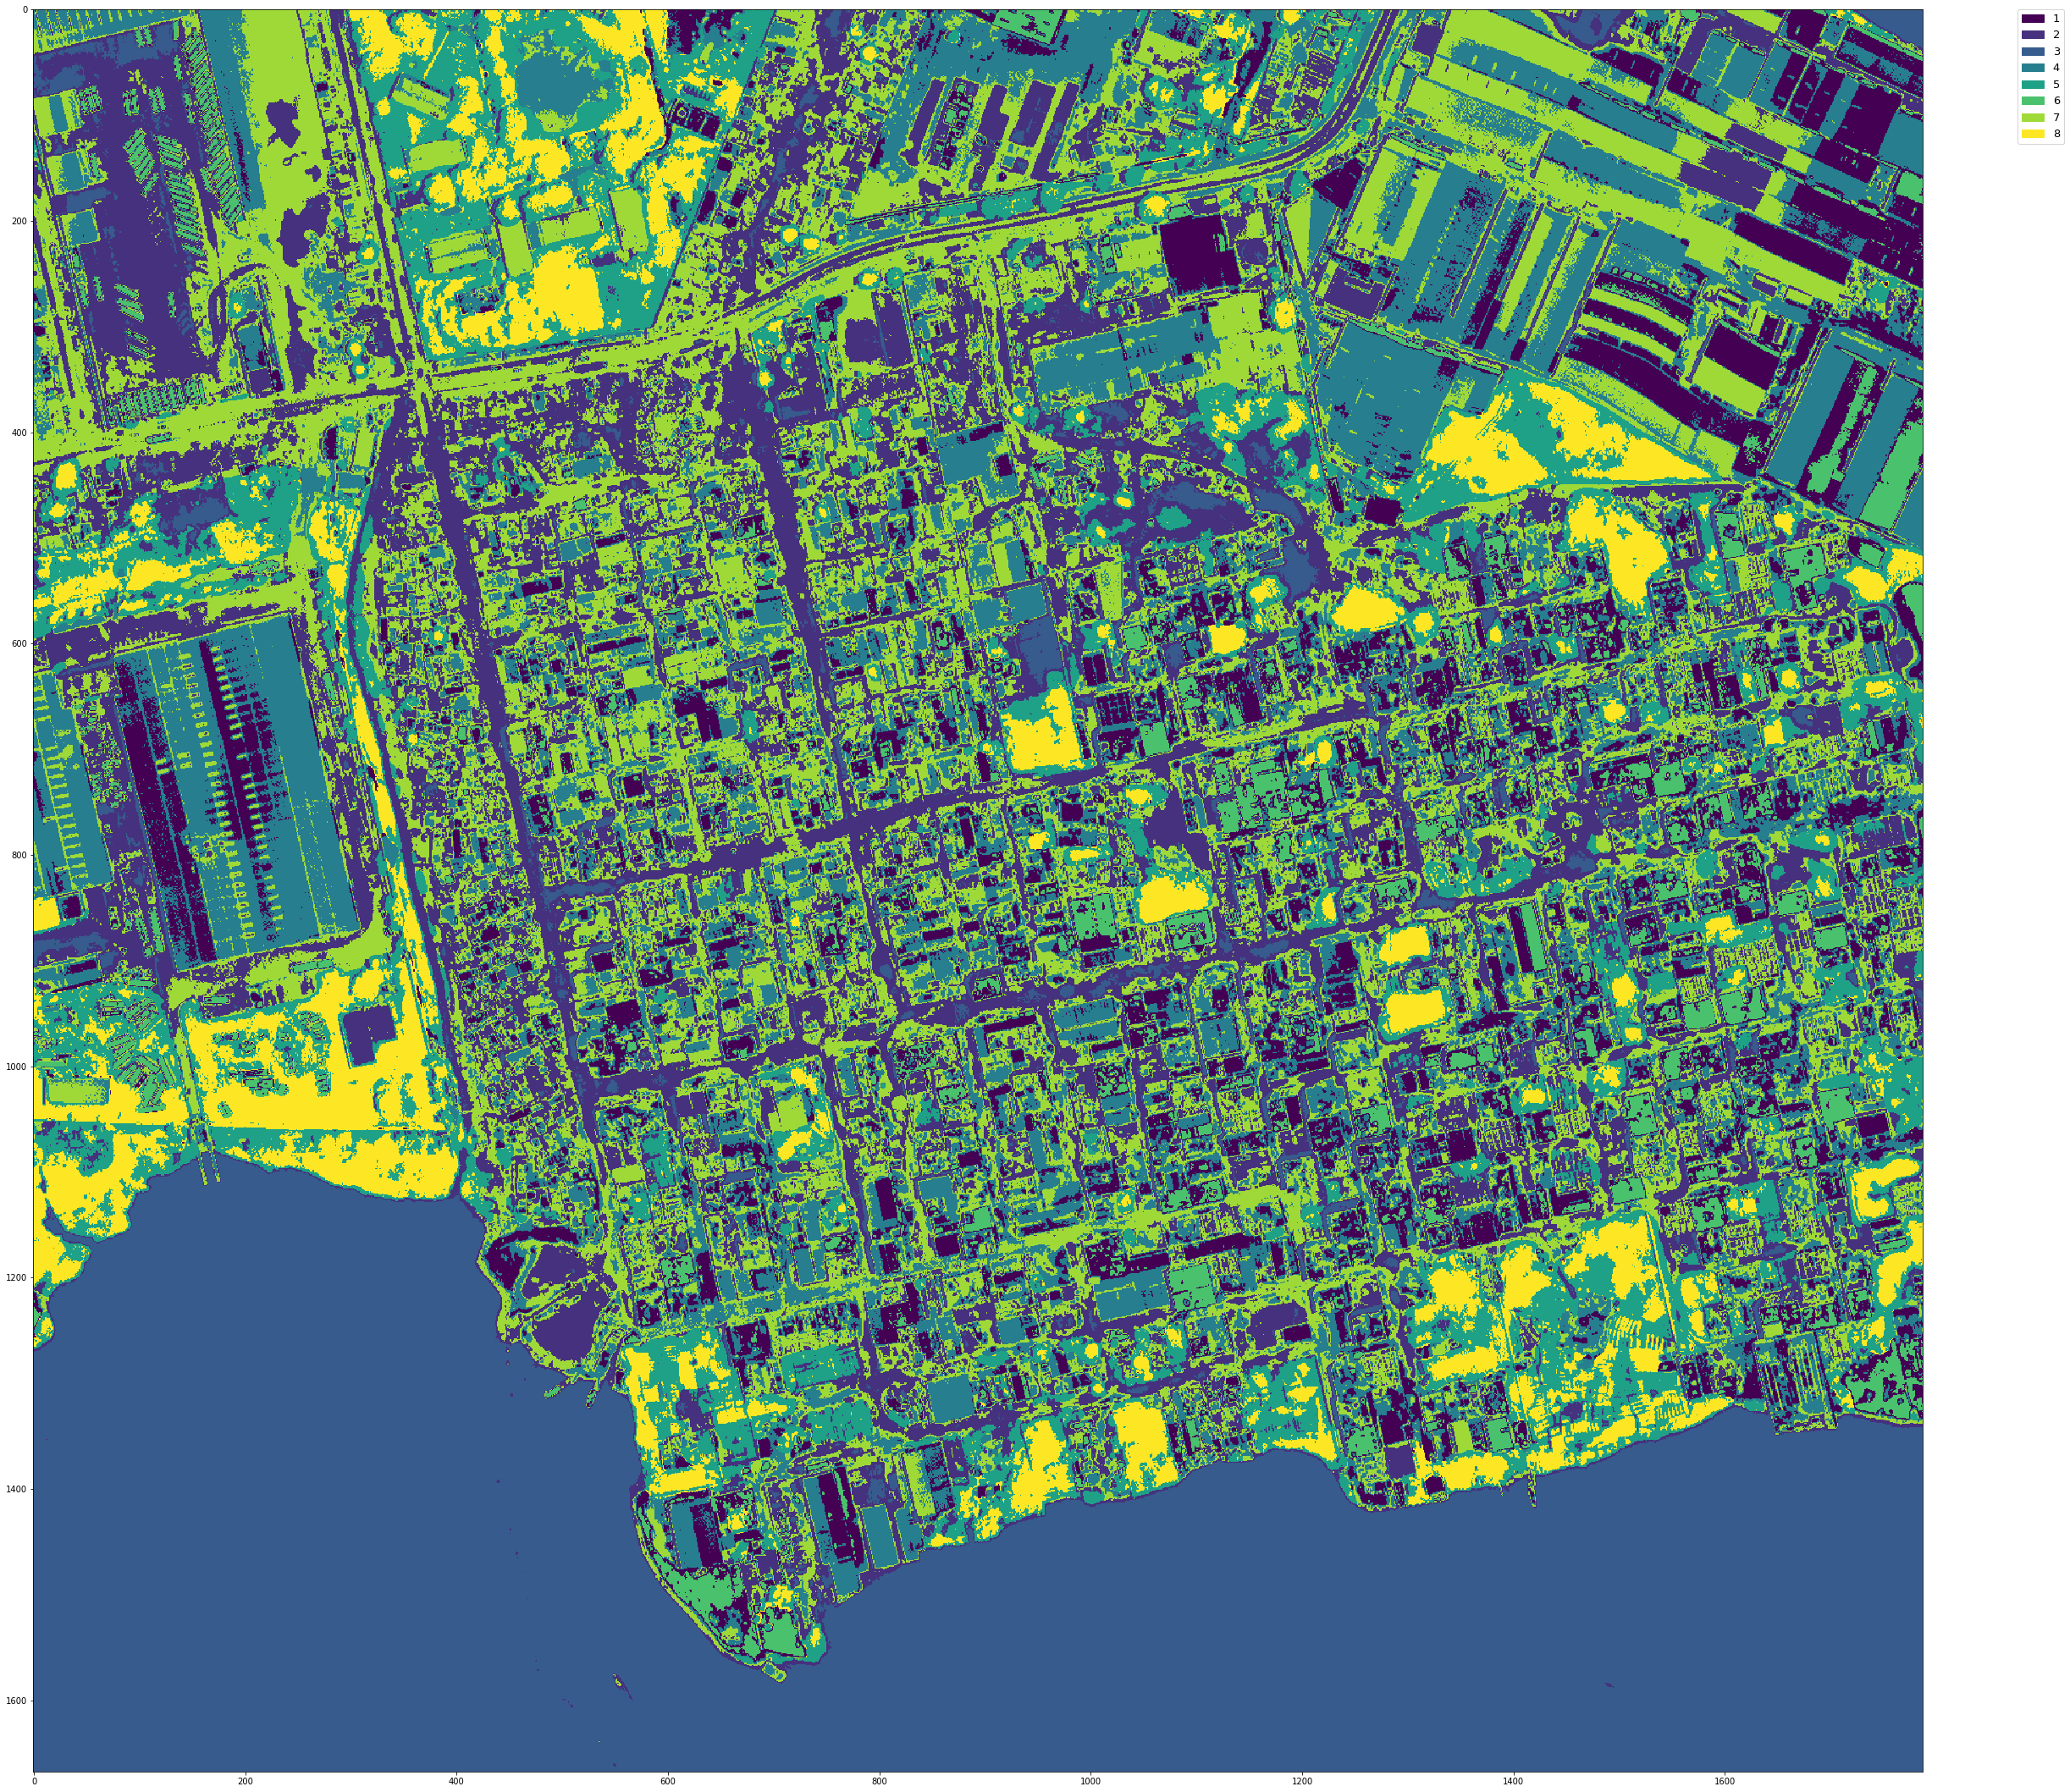

In [92]:
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_text = predictedClass_text.reshape(im2_arr.shape[:2])
im2 = ax.imshow(pred_data_text)
values = np.unique(pred_data_text)
cat_names = ["1","2","3","4","5","6","7","8"]
ep.draw_legend(im2,titles=cat_names)
# ax[1].imshow(bytescale(all_bands_stack))
plt.show()

# Kmeans on index stack

In [135]:
# Reshape array 
im_index_arr = np.rollaxis(index_stack, 0, 3)
X_index = im_arr.reshape(-1,8)

# Fit the KMeans classifier to the 8-band raster stack
predictedClass_index = clf_kmeans.fit_predict(X_index, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_index += 1

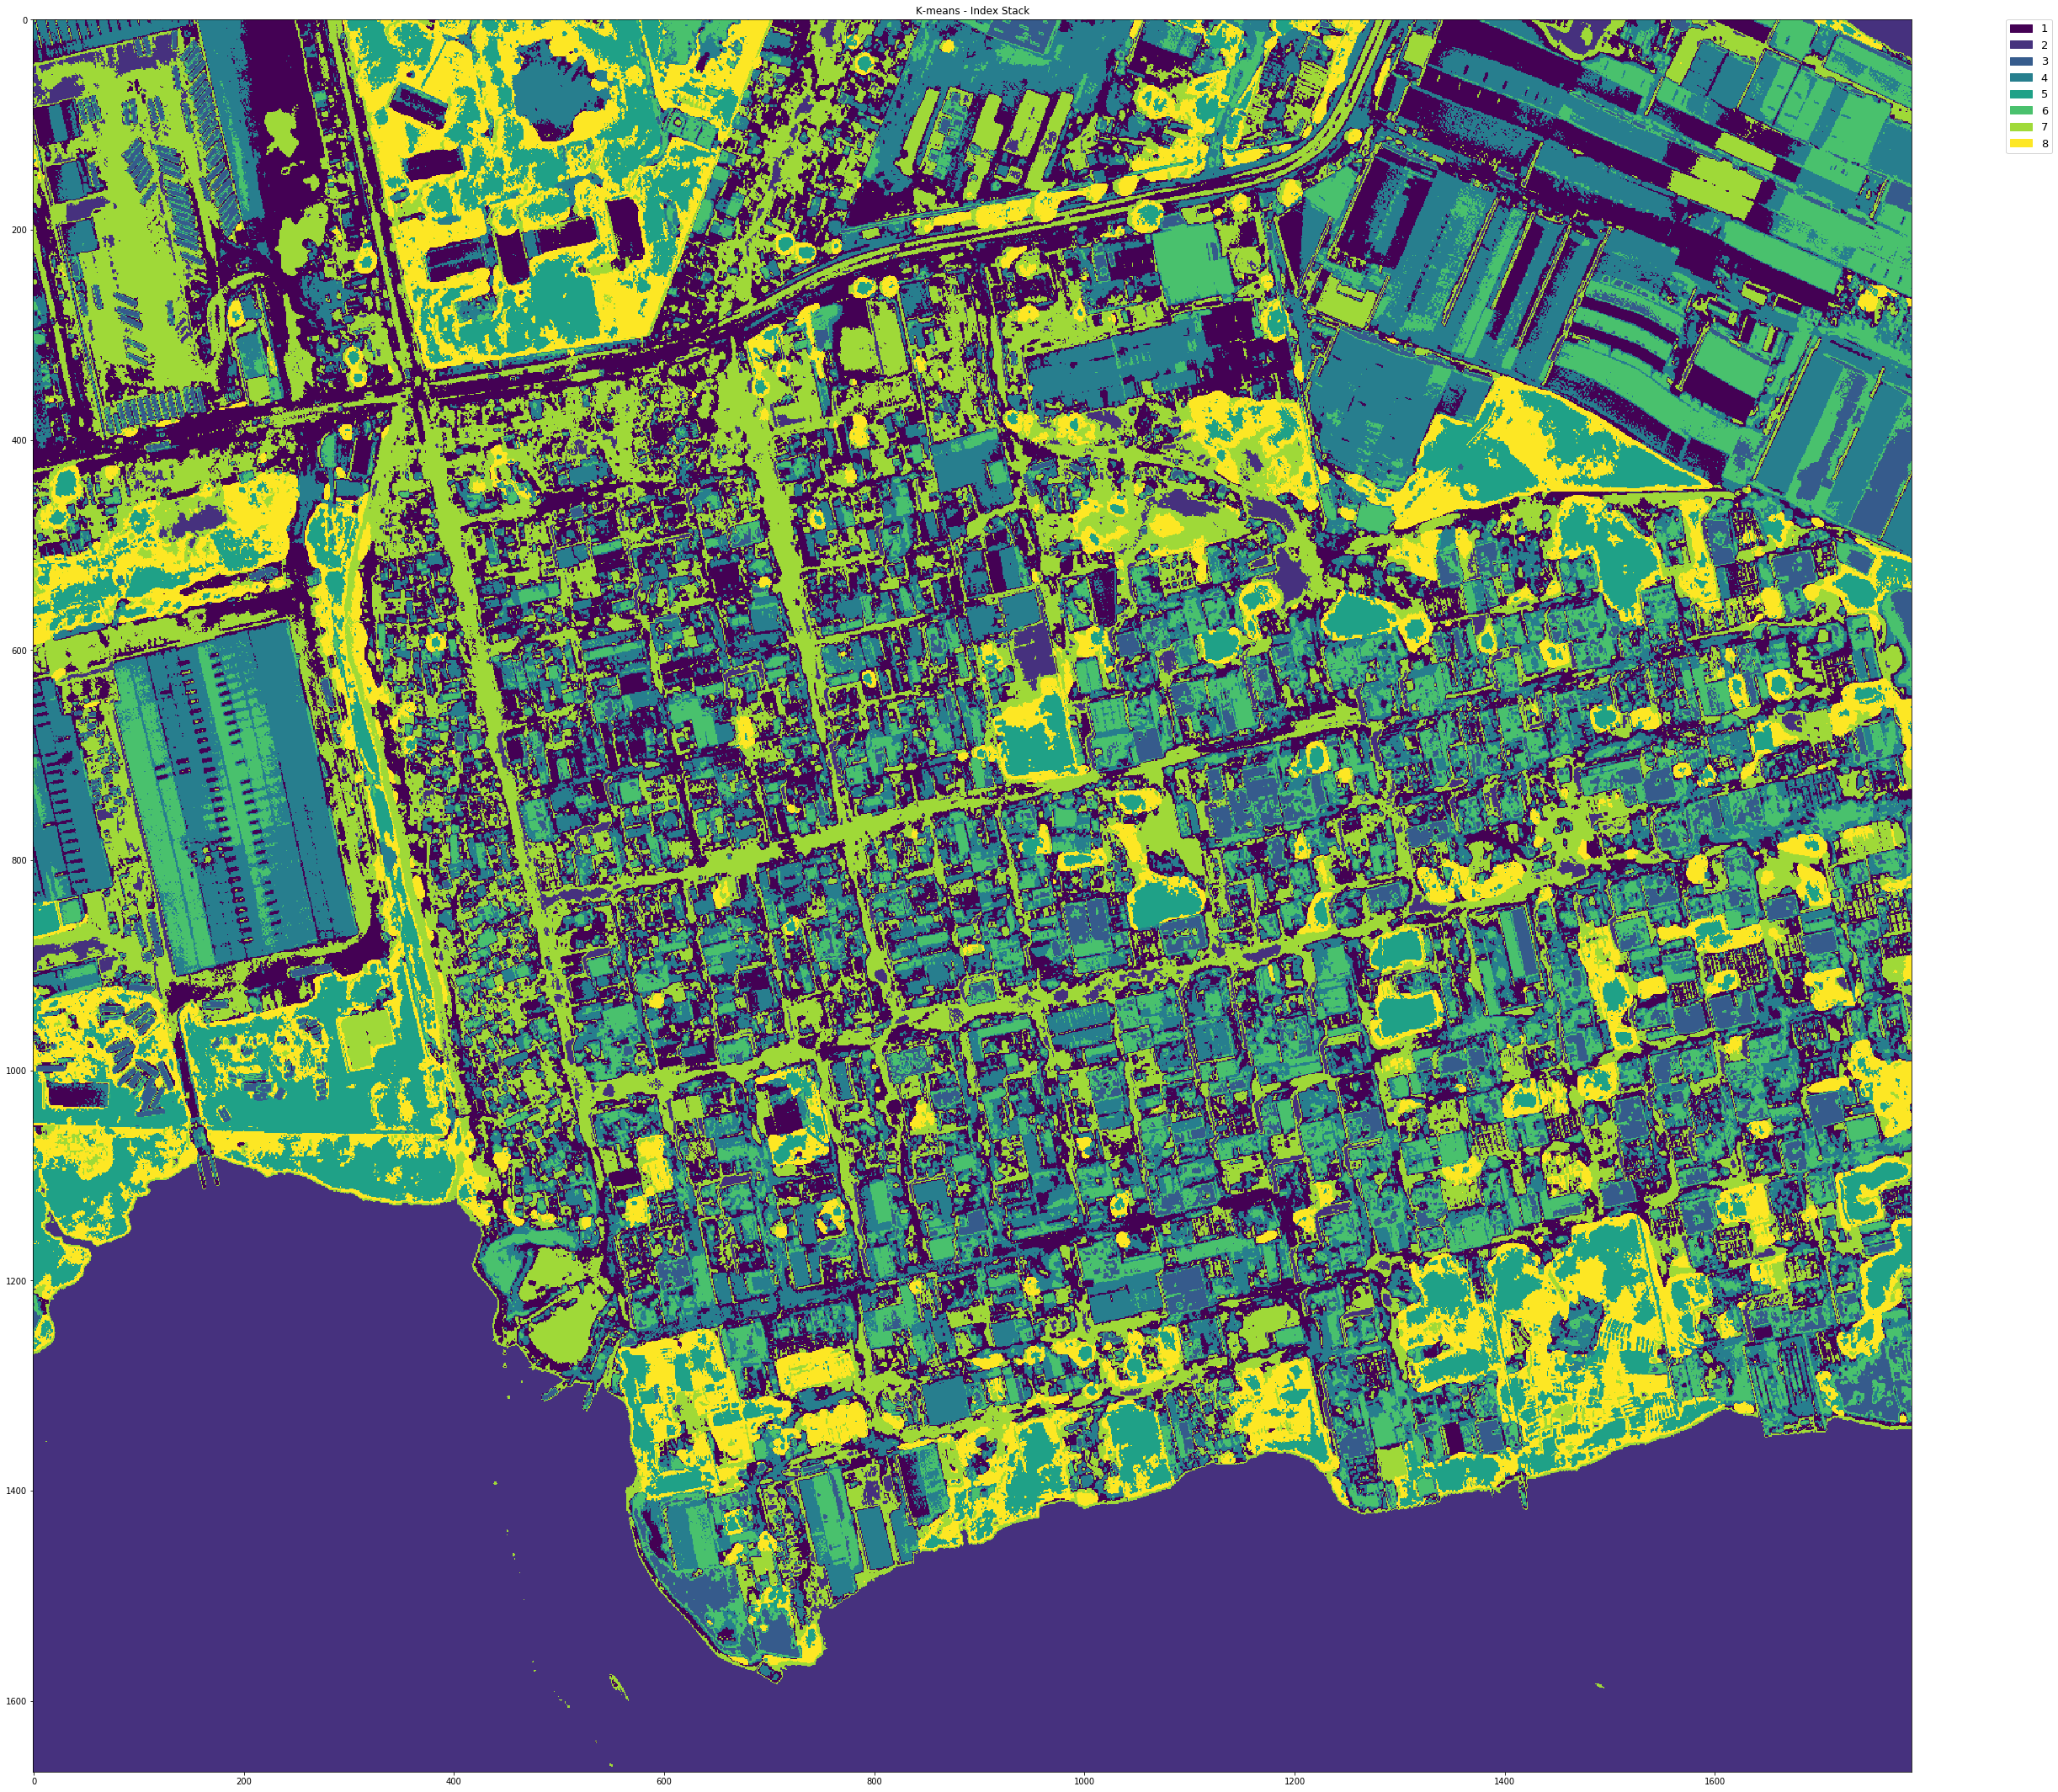

In [136]:
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_index = predictedClass_index.reshape(im_index_arr.shape[:2])
im = ax.imshow(pred_data_index)
values = np.unique(pred_data_index)
cat_names = ["1","2","3","4","5","6","7","8"]
ep.draw_legend(im,titles=cat_names)
plt.title("K-means - Index Stack")
# ax[1].imshow(all_bands_stack)
plt.show()

In [ ]:
# Add rasterio.sample to compare how well each output compares to actual 

# Try GMM 

In [103]:
from sklearn.mixture import GaussianMixture

#Predict GMM cluster membership
clf_gm = GaussianMixture(n_components=8)#.fit(X_ps).predict(X_ps)

In [98]:
# fit the GMM classifier to the 8 band stack
predictedClass_gm = clf_gm.fit_predict(X, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_gm += 1

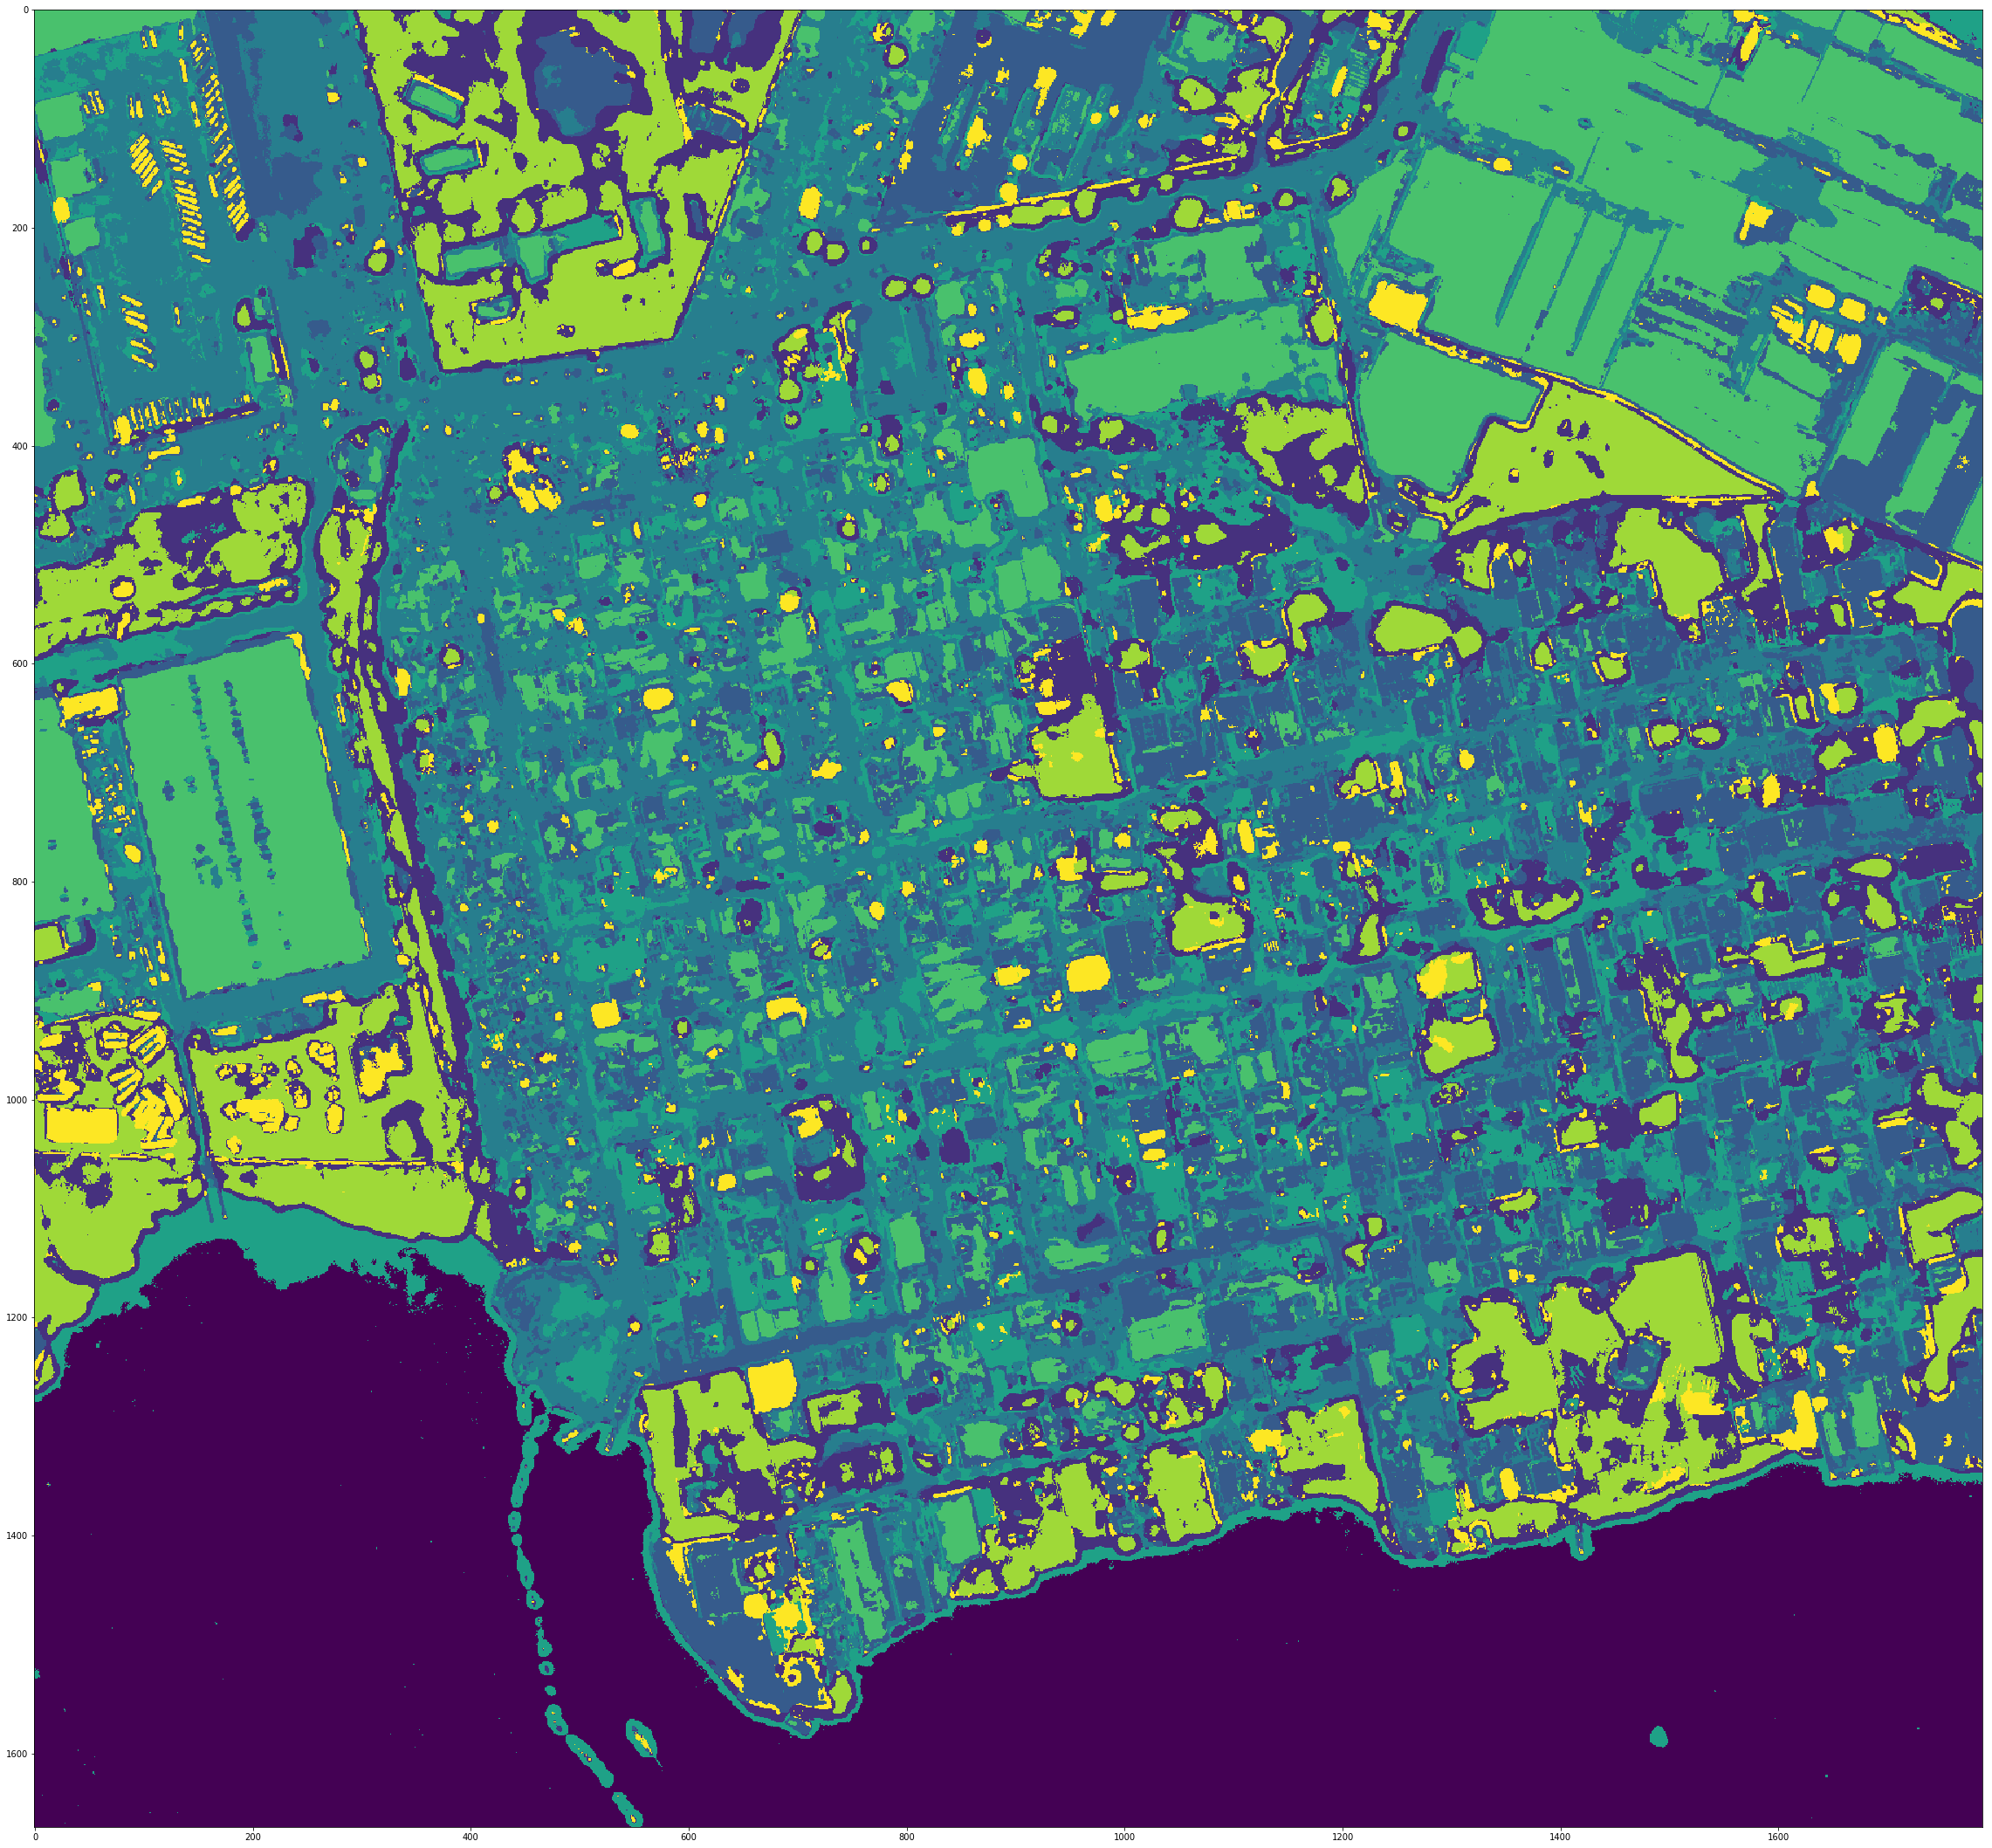

In [100]:
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm = predictedClass_gm.reshape(im_arr.shape[:2])
ax.imshow(pred_data_gm)
# ax[1].imshow(bytescale(all_bands_stack))
plt.show()

In [104]:
# fit the GMM classifier to the 8 band stack plus texture
predictedClass_gm_text = clf_gm.fit_predict(X_text, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_gm_text += 1

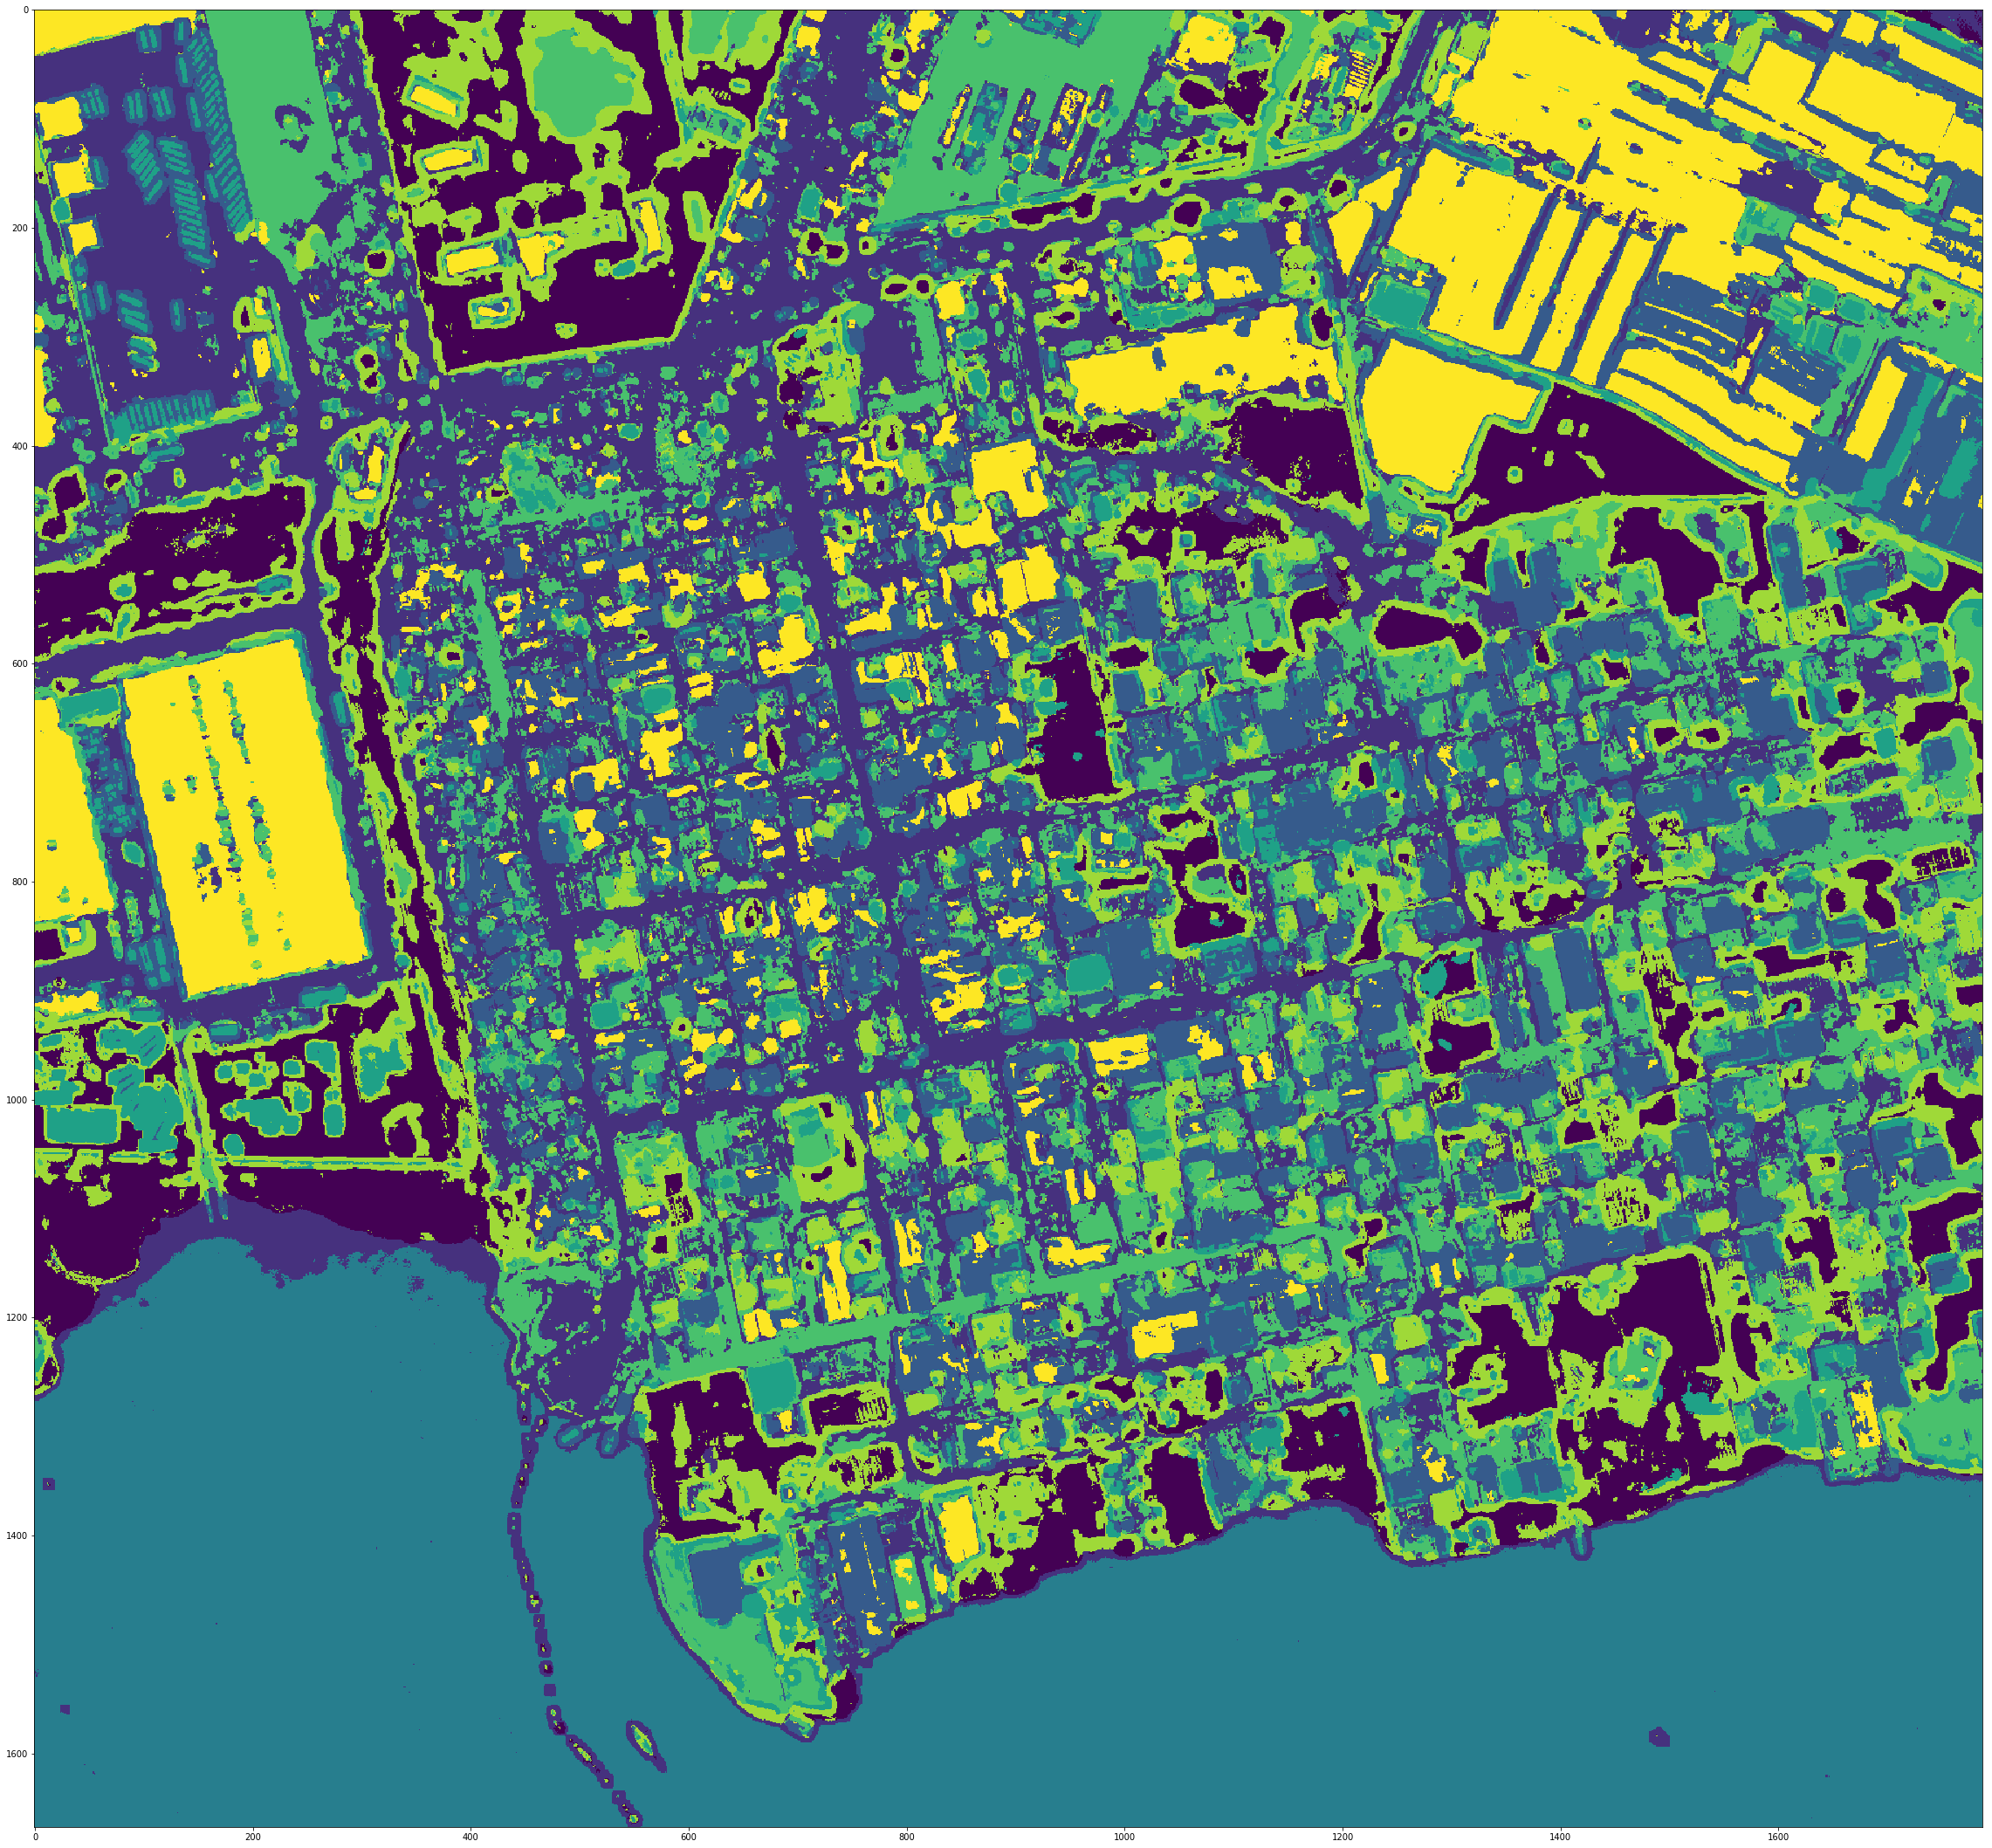

In [105]:
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm_text = predictedClass_gm_text.reshape(im_arr.shape[:2])
ax.imshow(pred_data_gm_text)
# ax[1].imshow(bytescale(all_bands_stack))
plt.show()

## Try clustering on RGB-NIR image

In [121]:
# Reshape RGB-NIR image
im_rgb_arr = np.rollaxis(rgb_bands, 0, 3)
X_rgb = im_rgb_arr.reshape(-1,4)

# Fit the KMeans classifier to RBG-NIR image
predictedClass_rgb = clf_pl.fit_predict(X_rgb, y=None)

# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_rgb += 1

In [ ]:
## show the result
fig, ax = plt.subplots(1,2, figsize = (40,40))
pred_data_rgb = predictedClass_rgb.reshape(im_rgb_arr.shape[:2])
ax.imshow(pred_data_rgb)
# ax[1].imshow(bytescale(all_bands_stack))
plt.show()

In [96]:
# Reshape predicted data (add axis) and write out files
pred_data_ps_out = pred_data[np.newaxis,:]
pred_data_gm_ps_out = pred_data_gm[np.newaxis,:]
pred_data_text_out = pred_data_text[np.newaxis,:]
pred_data_gm_text_out = pred_data_gm_text[np.newaxis,:]

with rio.open(outputs_path+'kmeans_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_out.astype('float32'))
with rio.open(outputs_path+'GMM_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm_ps_out.astype('float32'))
with rio.open(outputs_path+'kmeans_text_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_text_out.astype('float32'))
with rio.open(outputs_path+'GMM_text_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm_text_out.astype('float32'))

# Explore segmentation 

In [ ]:
# Import segmentation packages
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

# im_arr = np.rollaxis(rgb_bands, 0, 3)

# Try segmentation on index stack
im_index = np.rollaxis(index_stack,0,3)
# img = im_arr_ps 
img = im_index 
img[:,:,0] /= img[:,:,0].max()
img[:,:,1] /= img[:,:,1].max()
img[:,:,2] /= img[:,:,2].max()
img[:,:,3] /= img[:,:,3].max()
# img[:,:,4] /= img[:,:,4].max()
# img[:,:,5] /= img[:,:,5].max()
# img[:,:,6] /= img[:,:,6].max()
# img[:,:,7] /= img[:,:,7].max()

In [ ]:
# Define segmenters
segments_fz = felzenszwalb(img, scale=10, sigma=0.5, min_size=50)
# segments_slic = slic(img, n_segments=500, compactness=.1, sigma=1)
segments_quick = quickshift(img[:,:,:3], kernel_size=7, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img[:,:,:3]))
segments_watershed = watershed(gradient, markers=500, compactness=.001)

In [ ]:
# Print outputs
print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
# print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

In [ ]:
# Plot segmentation results

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img[:,:,:3], segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
# ax[0, 1].imshow(mark_boundaries(img[:,:,:3], segments_slic))
# ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img[:,:,:3], segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img[:,:,:3], segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

Look into issue with: ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [1]:
#segments_slic = slic(img, n_segments=500, compactness=.1, sigma=1)

In [ ]:
## For one of the segmented images, get some histogram measures for each band
def calc_meas(arr, m_type):
    
    try:
        if m_type == 'mean':
            res = np.mean(arr)

        elif m_type == 'std':
            res = np.std(arr)

        elif m_type == 'range':
            res = np.max(arr) - np.min(arr)

        elif m_type == 'entropy':
            pdf = np.histogram(arr, norm=True)
            pdf = pdf[pdf>0]
            ent = -np.sum(pdf*np.log2(pdf))
            res = ent
            
        else:
            res = 0
    except Exception as e:
        #print(e)
        res = 0
    
    return res


def regionHistMeasures(labeled_im, intensity_im, attrs=['mean']):
    
    num_bands = intensity_im.shape[-1]
    labels = np.unique(labeled_im)
    
    meas_arr = np.zeros((labels.size, len(attrs)*num_bands))
    meas_ls = []
    idx=0
    for meas_type in attrs:
        
        # iterate over the bands
        band_meas = []
        for b in range(num_bands):

            # get the band
            temp_arr = intensity_im[:,:,b]

            # iterate over labels
            seg_meas = []
            for j,lb in enumerate(labels):

                # get the labeled pixels
                temp_arr1 = temp_arr[labeled_im == lb]

                # calculate something
                meas = calc_meas(temp_arr1, meas_type)

                # append to seg list
                seg_meas.append(meas)
                
                
            # seg_meas is a list of the value for the [measurement for each label for the current band]
            # this is inserted into the result array by slicing the correct column
            meas_arr[:, idx] = seg_meas
            idx +=1
            
            # append to band list
            #band_meas.append(seg_meas)
            
            
        # append to attr list
        #meas_ls.append(band_meas)
        
    return meas_arr

In [ ]:
# test the segmentation classification

# for seg_im, title in zip([segments_fz, segments_slic, segments_quick, segments_watershed], ['fz', 'slic', 'quick', 'watershed']):
for seg_im, title in zip([segments_fz, segments_quick, segments_watershed], ['fz', 'quick', 'watershed']):
    
    
    seg_attrs = regionHistMeasures(seg_im, img, attrs=['mean', 'std', 'range', 'entropy'])
    seg_attrs = regionHistMeasures(seg_im, img, attrs=['mean', 'std'])
#     seg_attrs = regionHistMeasures(seg_im, img, attrs=['mean', 'std', 'entropy'])
    #seg_attrs = regionHistMeasures(seg_im, img, attrs=['mean', 'std', 'range'])
    
    ## now run the classifier on the image segments
    clf_seg = KMeans(n_clusters=nclass, random_state=10)

    # fit it on the segment table
    # fit the KMeans classifier
    predictedClass_seg = clf_seg.fit_predict(seg_attrs, y=None)

    # use the fit model
    # predictedClass = clf_pl.predict(X_pl)
    predictedClass_seg += 1

    ## reassign the segment image to these class labels
    labels = np.unique(seg_im)
    kmeans_seg_im = np.zeros(seg_im.shape)
    for i,lb in enumerate(labels):
        kmeans_seg_im[seg_im==lb] = predictedClass_seg[i]

    
    fig, ax = plt.subplots(1,2, figsize = (20,10))
    ax[0].imshow(kmeans_seg_im)
    ax[1].imshow(mark_boundaries(img[:,:,:3], seg_im))
    ax[1].set_title(title)
    
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_ps)
print(pca.explained_variance_)
print(pca.components_)

In [ ]:
plt.plot(X_ps[:, 0], X_ps[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

In [ ]:
from skimage import measure
from skimage import morphology

patch_labels = measure.label(all_bands_stack) 

In [3]:
from skimage import measure
from skimage import morphology

patch_labels = measure.label(pred_data_ps) 
props = measure.regionprops(patch_labels) 

# patchsize_thresh = 30
# small_patches = []
# for prop in props:
#     if prop.area < 2:
#         small_patches.append(prop.label)
# len(small_patches)

# Plot flood label layer 
fig, ax = plt.subplots(figsize=(20,10))
flood_cleaned_plot = ax.imshow(patch_labels, cmap='Set1')
ax.set(title="Flood Labels, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
plt.show()

NameError: name 'pred_data_ps' is not defined

In [35]:
len(props)

56257

In [36]:
help(measure.regionprops)

Help on function regionprops in module skimage.measure._regionprops:

regionprops(label_image, intensity_image=None, cache=True, coordinates=None)
    Measure properties of labeled image regions.
    
    Parameters
    ----------
    label_image : (N, M) ndarray
        Labeled input image. Labels with value 0 are ignored.
    
        .. versionchanged:: 0.14.2
            Previously, ``label_image`` was processed by ``numpy.squeeze`` and
            so any number of singleton dimensions was allowed. This resulted in
            inconsistent handling of images with singleton dimensions. To
            recover the old behaviour, use
            ``regionprops(np.squeeze(label_image), ...)``.
    intensity_image : (N, M) ndarray, optional
        Intensity (i.e., input) image with same size as labeled image.
        Default is None.
    cache : bool, optional
        Determine whether to cache calculated properties. The computation is
        much faster for cached properties, whereas t

In [2]:
label_1 = []
for prop in props[:10]:
#     if prop.label == 1:
#         label_1.append(prop.label)
    print(prop.label)
# len(label_1)

NameError: name 'props' is not defined

[3]